Dataset found at : https://github.com/nicknochnack/ImageClassification


Libraries used for now, will be updated whilst coding something useful


In [100]:
import tensorflow as tf
import os

avoid OOM errors by setting gpu usage


In [101]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Remove all images corrupted or bad


In [102]:
import cv2
import imghdr

In [103]:
data_dir = './data/'
image_extensions = ['jpeg','jpg','bmp','png']
os.listdir(data_dir)

['sad', 'happy']

Loop to remove all useless images


In [104]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Load Dataset using a Pipeline


In [105]:
import numpy as np
import matplotlib.pyplot as plt 

In [106]:
data = tf.keras.utils.image_dataset_from_directory('data',batch_size=32)  #change batch_size param in case you have low specs 

Found 305 files belonging to 2 classes.


In [107]:
data_iterator = data.as_numpy_iterator() #access generator from pipeline as iterator


rerun to get different batches


In [108]:
batch = data_iterator.next() #batch has 2 fields: data(image) and label
batch[1]

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

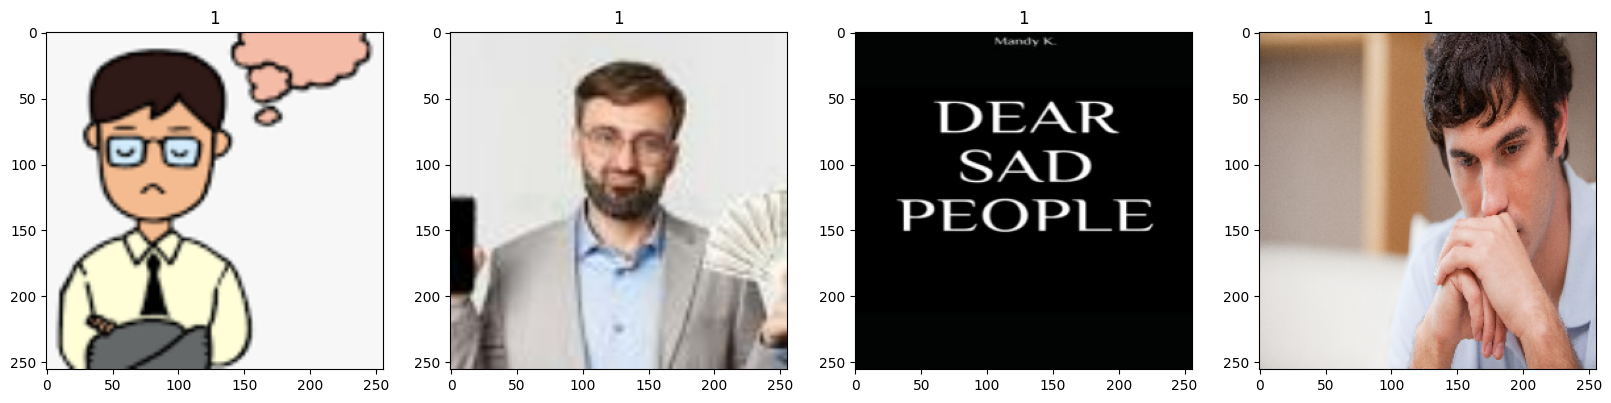

In [109]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    #ax[idx].title.set_text('happy' if batch[1][idx]<=0.5 else 'sad')
    ax[idx].title.set_text(batch[1][idx])

Preprocessing data
we gotta make it fast and good baby!


Scale data


In [110]:
data = data.map(lambda x,y :(x/255,y)) # x images (indp var) y label 255 scaling

In [111]:
data.as_numpy_iterator().next()

(array([[[[2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          [2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          [2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          ...,
          [3.27542901e-01, 3.27542901e-01, 3.27542901e-01],
          [3.29074740e-01, 3.29074740e-01, 3.29074740e-01],
          [3.29411775e-01, 3.29411775e-01, 3.29411775e-01]],
 
         [[2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          [2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          [2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          ...,
          [3.27542901e-01, 3.27542901e-01, 3.27542901e-01],
          [3.29074740e-01, 3.29074740e-01, 3.29074740e-01],
          [3.29411775e-01, 3.29411775e-01, 3.29411775e-01]],
 
         [[2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          [2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          [2.19607845e-01, 2.19607845e-01, 2.19607845e-01],
          ...,
          [3.27542901e-01, 3.27542901e-01, 3.2754

In [112]:
len(data)

10

So now we split the data into test, trainain and validation sets.


In [113]:
train_size= int(len(data)*.7)
val_size= int(len(data)*.2)
test_size= int(len(data)*.1)

print('Train size:', train_size, 'Validation Size : ', val_size,'Testing  Size:' , test_size )   ##70% for training and rest two are used as validation.   

Train size: 7 Validation Size :  2 Testing  Size: 1


In [114]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)   ## skipping the train part to get val set from remaining dataset (remaining is testset )
test = data.skip(train_size+val_size).take(test_size )   ## skipping the train & val part to get testing set from remaining dataset    

In [115]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Add layers to the model


In [116]:
from tensorflow.keras.models import Sequential    
from tensorflow.keras.layers import Conv2D , Dense, Flatten,MaxPooling2D

model = Sequential()     ## Initialize a sequential model  

model.add(Conv2D(16, (3,3),1,activation ='relu',input_shape = (256,256,3)))
model.add(MaxPooling2D())   ## Max pool layer for downsampling the image data  

model.add(Conv2D (32 , (3,3),1,activation ='relu'))   
model.add(MaxPooling2D())     ## Max pool layer for downsampling the image data     


model.add(Conv2D(16, (3,3),1,activation ='relu'))
model.add(MaxPooling2D())   ## Max pool layer for downsampling the image data  

model.add(Flatten() )     ## Flattern Layer to convert our input into a single long vector so that we can feed it in fully connected layers 

model.add(Dense(256,activation ='relu'))     ## Fully Connected layer with one neuron (dense layer), and use ReLU as activation function  
model.add(Dense(1 , activation = 'sigmoid') )     ## Output Layer (also called Dense Layers) using sigmoid Activation Function for binary classification   

In [117]:
from tensorflow.keras.metrics import binary_crossentropy
model.compile(optimizer = 'adam', loss  = binary_crossentropy, metrics =  ['accuracy'])   ## Compile the model with Adam optimiser and Binary Cross Entropy Loss function  (for a multi-class classification problem)   

In [118]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Now we train


In [119]:
import tensorboard


logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)   ## Tensoboard callback for visualizing the training process in a web browser   

In [120]:
hist = model.fit(train, epochs=30 , validation_data = val,callbacks  = [tensorboard_callback])   

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.5469 - loss: 1.2375 - val_accuracy: 0.7031 - val_loss: 0.6835
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.6059 - loss: 0.6821 - val_accuracy: 0.7812 - val_loss: 0.6427
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.6585 - loss: 0.6294 - val_accuracy: 0.4688 - val_loss: 0.7272
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.5332 - loss: 0.6648 - val_accuracy: 0.6094 - val_loss: 0.6354
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.6825 - loss: 0.6267 - val_accuracy: 0.7344 - val_loss: 0.5849
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.7742 - loss: 0.5455 - val_accuracy: 0.7344 - val_loss: 0.5577
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.7081 - loss: 0.4937 - val_accuracy: 0.8125 - val_loss: 0.4180
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.7955 - loss: 0.4811 - val_accuracy: 0.7812 - val_loss:

Look at the performance


In [121]:
# Plotting Accuracy and Loss over Epochs for Training & Validation Data sets.  
# https:%tensorboard --logdir logs to look it using tensorboard

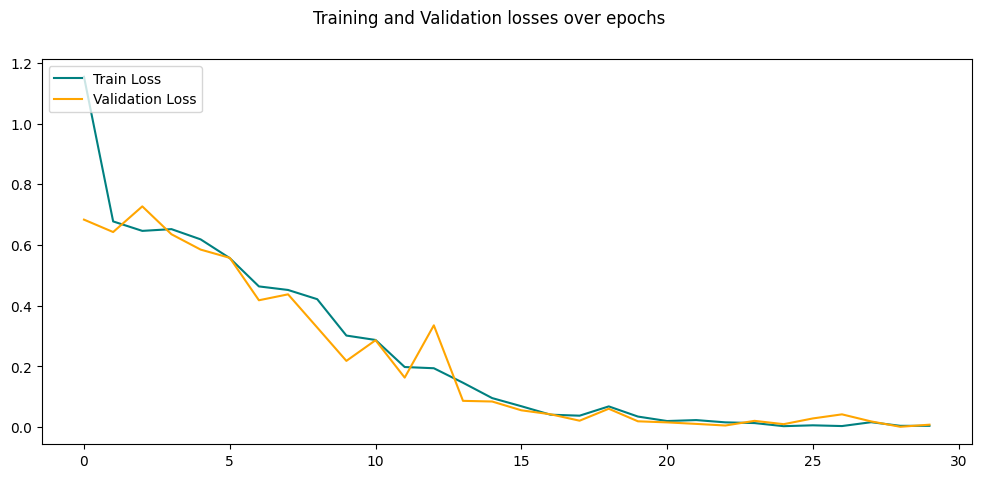

In [122]:
fig = plt.figure(figsize = (12,5))    # Create a new figure instance """    
plt.plot(hist.history['loss'],color= 'teal', label = 'Train Loss')    
plt.plot(hist.history ['val_loss'], color = "orange",label  ="Validation Loss")   
fig.suptitle('Training and Validation losses over epochs ')      
plt.legend(loc= "upper left")
plt.show()

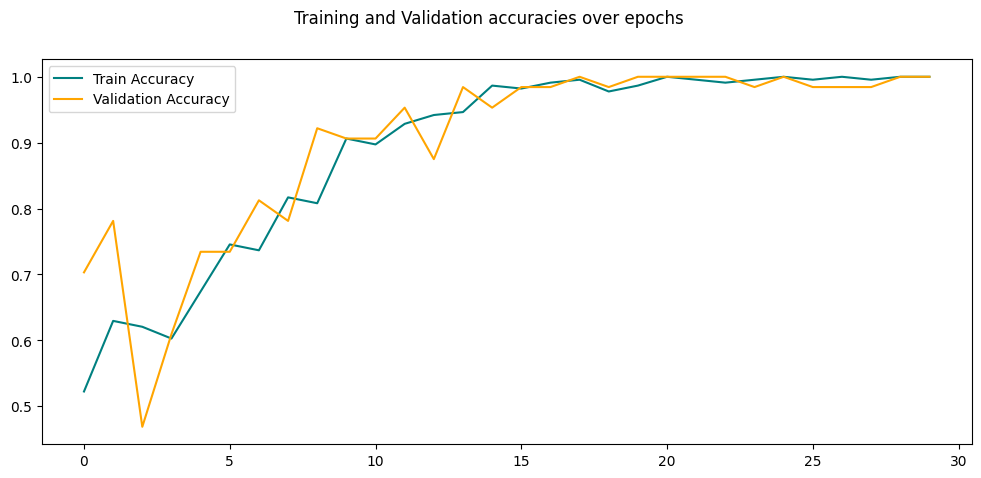

In [123]:
fig = plt.figure(figsize = (12,5))    # Create a new figure instance """    
plt.plot(hist.history['accuracy'],color= 'teal', label = 'Train Accuracy')    
plt.plot(hist.history ['val_accuracy'], color = "orange",label  ="Validation Accuracy")   
fig.suptitle('Training and Validation accuracies over epochs ')      
plt.legend(loc= "upper left")
plt.show()

Evaluate performance


In [124]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re =  Recall()
acc = BinaryAccuracy()   


In [125]:
len(test)

1

In [126]:
for batch in test.as_numpy_iterator():   
    X , y =batch
    predictions = model .predict(X)   
    pre.update_state(y,predictions )
    re.update_state(y,predictions )
    acc.update_state(y,predictions )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


In [127]:
print(f'Precision: {pre.result().numpy()*100:.2f}%, Recall : {re.result().numpy() *  100 }% , Accuracy : {acc.result().numpy() *  100 }%')

Precision: 100.00%, Recall : 100.0% , Accuracy : 100.0%


Save model


In [128]:
# Importing necessary libraries for saving and loading models in TensorFlow's Keras API load
model.save("emotion_detection.keras")   # Saving the trained emotion detection model to disk 


In [129]:
from tensorflow.keras.models import load_model
loaded_model = load_model('emotion_detection.keras')   # Loading saved Model for prediction on new data using loaded weights (optional)    

In [142]:
from PIL import Image
import random 
def get_random_image_path(folder_path):
    try:
        files = os.listdir(folder_path)
        # Filter the list to get only image files 
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        if not images:
            print("No images found in the specified folder.")
            return None

        # Choose a random image file
        random_image = random.choice(images)
        random_image_path = os.path.join(folder_path, random_image)
        print(f"Here the random image path from the folder:")
        return random_image_path
      
    except Exception as e:
        print(f"An error occurred while selecting image randomly: {e}")
        return None


def display_image(image_path):
    try:
        if image_path and os.path.isfile(image_path):
            with Image.open(image_path) as img:
                display(img)
                print(f"Displayed image: {image_path}")
        else:
            print(f"Invalid image path: {image_path}")
    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")

def show_random_image_from_folder(folder_path):

    random_image_path = get_random_image_path(folder_path)
    display_image(random_image_path)
    img_cv = cv2.imread(random_image_path)
    resized  = tf.image.resize(img_cv,(256,256))
    return model.predict(np.expand_dims(resized/255,0))

Here the random image path from the folder:


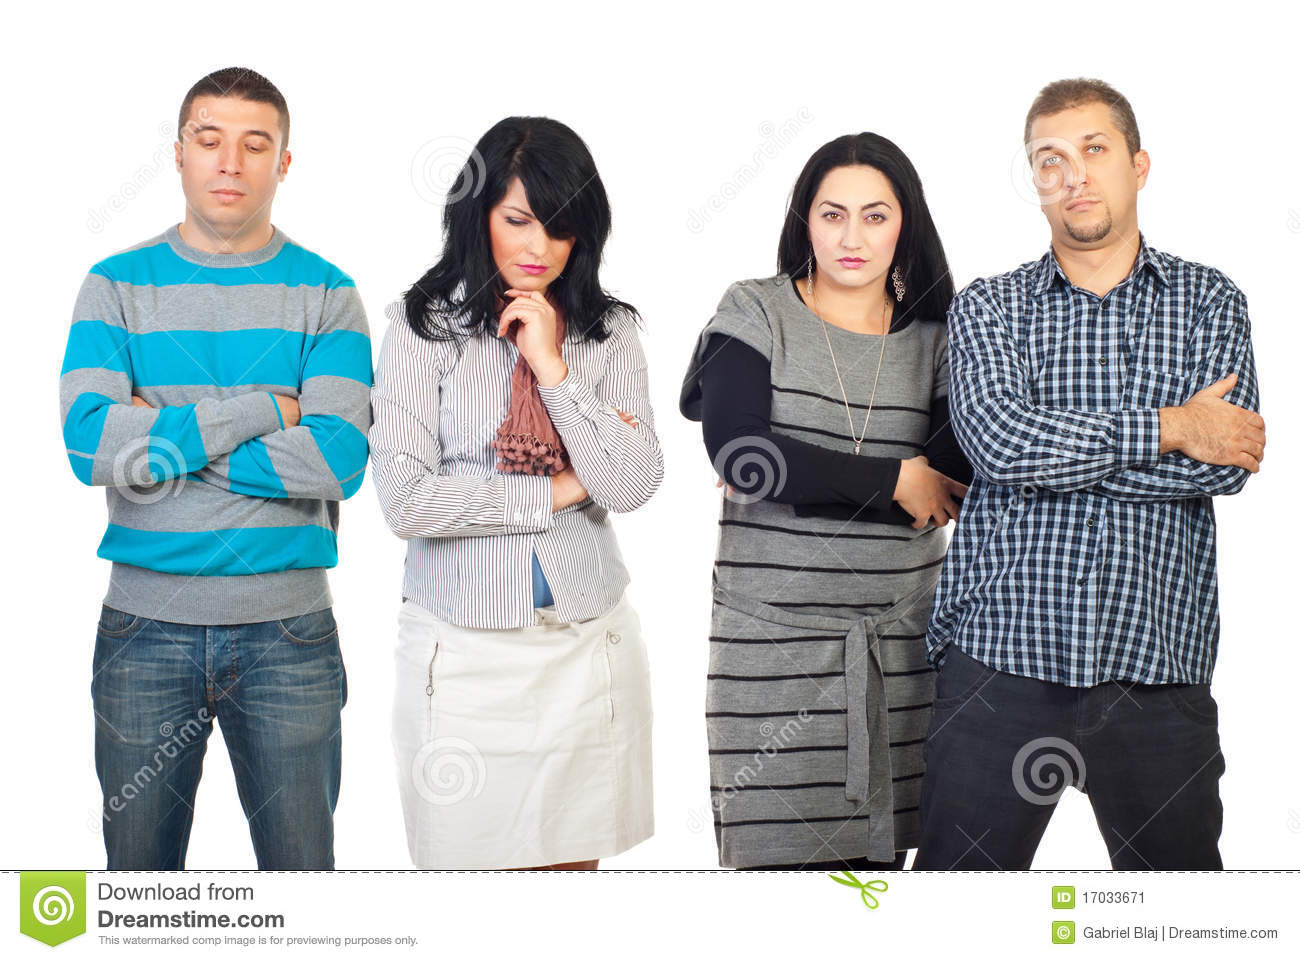

Displayed image: ./data/sad/sad-group-people-problems-17033671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Emotion: happy
[[0.30234224]]


In [148]:
folder_path = ['./data/happy', './data/sad']
random_path = random.choice(folder_path)
if os.path.isdir(random_path):
    result =show_random_image_from_folder(random_path)
    print('Predicted Emotion:', 'happy' if  result  <0.5 else 'sad') 
    print(result)
else:
    print(f" The specified folder does not exist: {random_path}")